# 데이터 전처리 과정

## 목표
### 자연어로 입력된 시공 내용으로부터 다음 정보를 추출하는 파인튜닝 모델을 학습시킬 수 있는 데이터셋을 만드는 것
* 구분
* 작업 내용
    * 규격
    * 개수
* 위치

In [1]:
import os
import copy
import json
import base64
from pydantic import BaseModel
from tkinter import Tk
from tkinter.filedialog import askopenfilename, askdirectory

from openai import OpenAI

In [2]:
# API KEY 파일을 선택함
root = Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
openai_api_key_path = askopenfilename()
%gui tk

In [3]:
with open(openai_api_key_path, 'r') as f:
    openai_api_key = f.read()
    f.close()

In [4]:
client = OpenAI(api_key=openai_api_key)

# 첫 번째 시도

## 1. 문자열 추출 테스트
### 목표
    OpenAI API를 이용해 이미지에서 "내용"에 해당하는 텍스트를 추출하기

In [ ]:
# 이미지를 선택함
root.call('wm', 'attributes', '.', '-topmost', True)
image_path = askopenfilename()
%gui tk

In [15]:
# 이미지를 base64로 인코딩함
with open(image_path, "rb") as image_file:
    base64_image = base64.b64encode(image_file.read()).decode('utf-8')

In [35]:
# 시스템 프롬트트
system_prompt = "You are the chief construction manager at a construction company, responsible for organizing work photos sent from the site. When you receive a work photo combined with a table of work information, extract the text in according to the given structure."

In [32]:
# 텍스트 추출 테스트
response = client.chat.completions.create(
  model="gpt-4o-2024-08-06",
  messages=[
    {
      "role": "system",
      "content": [
        {
          "type": "text",
          "text": system_prompt
        }
      ]
    },
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": ""
        },
        {
          "type": "image_url",
          "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}"
          }
        }
      ]
    }
  ],
  temperature=0,
  max_tokens=256,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0,
  response_format={
    "type": "json_schema",
    "json_schema": {
      "name": "extract_construction_info",
      "strict": True,
      "schema": {
        "type": "object",
        "properties": {
          "content": {
            "type": "string",
            "description": "Text under the '내용' section in the table"
          }
        },
        "additionalProperties": False,
        "required": [
          "content"
        ]
      }
    }
  }
)

In [44]:
response.choices[0].message.content

'{"content":"7번 벽체 D 50*2 단면"}'

## 2. 데이터셋 이미지 텍스트 추출
### 목표
    OpenAI Batch API를 사용해 모든 이미지에서 텍스트를 추출하기
***
### 1. 배치 파일 준비하기
#### 모든 이미지를 base64로 변환하기

In [5]:
# base64로 변환한 이미지 리스트
base64_image_set = []

In [6]:
# 모든 현장 폴더가 저장된 폴더를 가져옴
root = Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
image_set_folder_path = askdirectory()
%gui tk

In [7]:
# 해당 경로의 이미지를 base64 문자열로 반환하는 함수
def convert_to_base64(image_path: str) -> str:
    with open(image_path, "rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode('utf-8')

    return base64_image

In [8]:
# 각 현장별 폴더에 있는 이미지를 모두 가져옴
site_name_list = os.listdir(image_set_folder_path)

for site_name in site_name_list:
    resized_image_folder_path = f"{image_set_folder_path}/{site_name}/resized/"
    # 해당 폴더 내에 있는 모든 이미지 파일 이름을 불러옴
    image_name_list = os.listdir(resized_image_folder_path)
    
    for index, image_name in enumerate(image_name_list):
        # 각 이미지를 base64로 변환해 저장함
        base64_image = convert_to_base64(resized_image_folder_path + image_name)
        base64_image_set.append(base64_image)

    print(f"현장명: {site_name} - {index + 1}개의 이미지가 추가됨")

현장명: (광장이엠씨) 마곡CP4 개발사업 - 755개의 이미지가 추가됨
현장명: (백산이엔씨) 침산 포스코 더샵 프리미엘 - 32개의 이미지가 추가됨
현장명: (세방테크) 힐스테이트 봉담프라이드시티 - 642개의 이미지가 추가됨
현장명: (중원엔지니어링) LG 여의도 트윈타워 리모델링 - 91개의 이미지가 추가됨
현장명: (환경이엔지) 힐스테이트 장안 센트럴 - 46개의 이미지가 추가됨


In [ ]:
# 시스템 프롬프트
system_prompt_text = "You are the chief construction manager at a construction company, responsible for organizing work photos sent from the site. When you receive a work photo combined with a table of work information, extract the text in according to the given structure."
system_prompt = {
    "role": "system",
    "content": [{
        "type": "text",
        "text": system_prompt_text
    }]
}

# 유저 프롬트트
user_prompt = {
    "role": "user",
    "content": [{
        "type": "text",
        "text": ""
    },
    {
        "type": "image_url",
        "image_url": {
            "url": "data:image/jpeg;base64,{0}"
        }
    }]
}

# 응답 구조
json_schema = {
  "name": "extract_construction_info",
  "strict": True,
  "schema": {
    "type": "object",
    "properties": {
      "content": {
        "type": "string",
        "description": "Text under the '내용' section in the table"
      }
    },
    "additionalProperties": False,
    "required": [
      "content"
    ]
  }
}

# 배치 태스크 조조
task_schema = {
    "custom_id": "task-{0}",
    "method": "POST",
    "url": "/v1/chat/completions",
    "body": {
        "model": "gpt-4o-2024-08-06",
        "temperature": 0.1,
        "response_format": {
            "type": "json_schema",
            "json_schema": json_schema
        },
        "messages": [
            system_prompt,
            user_prompt
        ]
    }
}

In [15]:
# 배치 파일을 저장할 위치 설정
# dataset/batches 폴더에 저장하였음
root.call('wm', 'attributes', '.', '-topmost', True)
batch_file_folder = askdirectory()
%gui tk

In [20]:
# 배치 파일 생성
batch_file_index = 0

for index, base64_image in enumerate(base64_image_set):
    batch_file_path = batch_file_folder + f"/batch_tasks{batch_file_index}.jsonl"
    
    with open(batch_file_path, 'a') as file:
        task = copy.deepcopy(task_schema)
        # 커스텀 ID 수정
        task["custom_id"] = task["custom_id"].format(index)
        # 유저 프롬프트에 base64로 변환된 이미지 적용
        image_field = task["body"]["messages"][1]["content"][1]["image_url"]
        image_field["url"] = image_field["url"].format(base64_image)
        # 파일에 배치 태스크 작성
        file.write(json.dumps(task) + '\n')

    # 1개의 배치 파일에 100개의 태스크씩 작성
    if index != 0 and index % 100 == 0:
        batch_file_index += 1
    

### 2. 배치 작업 실행
#### 작업은 OpenAI Platform에서 진행하였음
#### 작업 결과는 database/batch outputs 폴더에 저장하였음

In [8]:
# 배치 작업 결과가 저장된 폴더를 선택함
root = Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
batch_output_folder = askdirectory()
%gui tk

In [10]:
# 배치 결과의 각 라인에서 추출한 텍스트에 접근해 반환하는 함수
def get_content(batch_output_line):
    content = (batch_output_line.get('response')
                                .get('body')
                                .get('choices')[0]
                                .get('message')
                                .get('content'))
    
    return json.loads(content).get('content')

In [19]:
# 선택한 폴더에서 모든 파일을 불러옴
outputs = []

for index in range(16):
    # 배치 결과 파일의 경로
    batch_output_file_path = f"{batch_output_folder}/{index}_output.jsonl"
    
    with open(batch_output_file_path) as batch_output_file:
        outputs += [
            get_content(json.loads(line))
            for line in batch_output_file
        ]

outputs[0]

'1번, 벽체, 덕트 100*2단면'

In [23]:
outputs[327]

'7-STS-FD 단판 1200*700.1200*700 양면'

### !문제 발생!
#### 1. 자원 절약을 위해 해상도를 낮춰 추출을 시도하였으나 정확도가 상당히 떨어짐
####     -> 해상도를 변경하지 않고 시도해볼 것
#### 2. Playground에서의 응답과 Batch API에서의 응답의 차이가 존재함
####     -> Temperature 등의 매개변수를 Playground와 동일하게 설정할 것

***
# 두 번째 시도

## 1. 표 영역 크롭
### 목표
    해상도는 유지하면서 자원을 절약할 수 있도록 이미지에서 표 영역만 크롭하기

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [7]:
# 이미지를 선택하는 함수
def select_image():
    root = Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)
    image_path = askopenfilename()
    %gui tk
    
    return image_path

In [401]:
# 윤곽선이 이미지의 좌측 하단에 위치하는지 검사하는 함수
def is_contour_at_bottom_left(image, contour):
    # 윤곽선을 둘러싸는 사각형
    x, y, w, h = cv2.boundingRect(contour)

    # 이미지의 크기
    image_width, image_height, _ = image.shape

    
    # 사각형의 중심이 왼쪽 하단에 있는지 확인
    center_x = x + w / 2
    center_y = y + h / 2

    if center_x > image_width / 2 or center_y < image_height / 2:
        return False
     
    """
    # 사각형의 왼쪽 하단 꼭짓점이 이미지의 왼쪽 하단에 있는지 확인
    left_bottom_point = np.array()
    """

    return True

In [ ]:
# 윤곽선이 사각형인지 검사하는 함수
def is_contour_rect(contour, tolerance=0.02):
    # 윤곽선을 다각형으로 근사함
    epsilon = tolerance * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    # 윤곽선이 사각형인지 확인
    return len(approx) == 4

In [367]:
# 하얀색을 제외한 색은 모두 검정색으로 처리하는 함수
def mask_white(image):
    masked_image = np.copy(image)
    
    lower_white = np.array([253, 253, 253])
    upper_white = np.array([255, 255, 255])

    mask = cv2.inRange(image, lower_white, upper_white)
    mask_inverse = cv2.bitwise_not(mask)

    # 하얀색을 제외한 색은 모두 검정색으로 처리함
    masked_image[mask_inverse == 255] = [0, 0, 0]
    return masked_image

In [ ]:
# 윤곽선을 둘러싸는 사각형을 그리는 함수
def draw_contour_rect(image, contour):
    x, y, w, h = cv2.boundingRect(contour)
    
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

In [333]:
# 윤곽선 영역을 크롭하는 함수
def crop_contour_area(image, contour):
    x, y, w, h = cv2.boundingRect(contour)

    return image[y: y + h, x: x + w]

### 테스트

In [389]:
image_path = select_image()

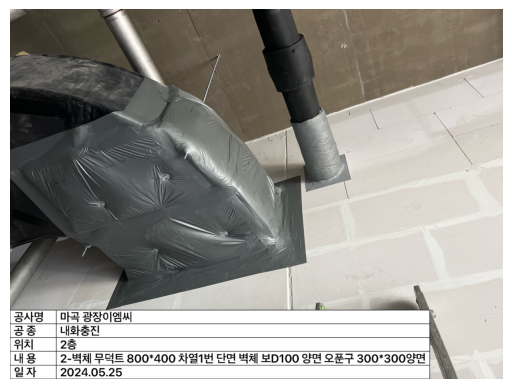

In [390]:
image = cv2.imread(image_path)

# 이미지 출력
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

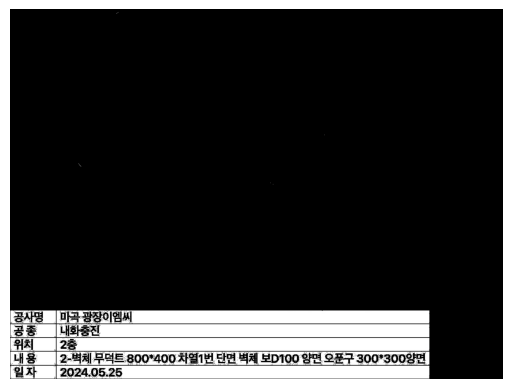

In [391]:
masked_image = mask_white(image)

# 이미지 출력
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [392]:
gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

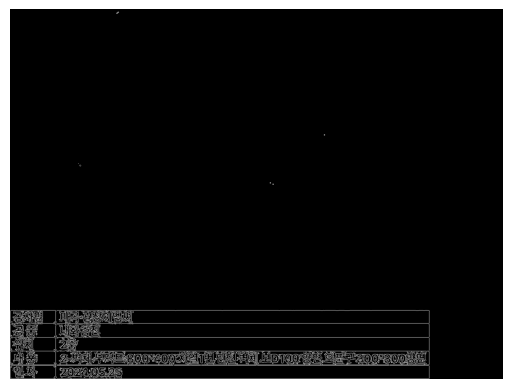

In [393]:
# 엣지(색이 급격하게 변하는 부분) 검출
edged = cv2.Canny(gray, 20, 70)

# 이미지 출력
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

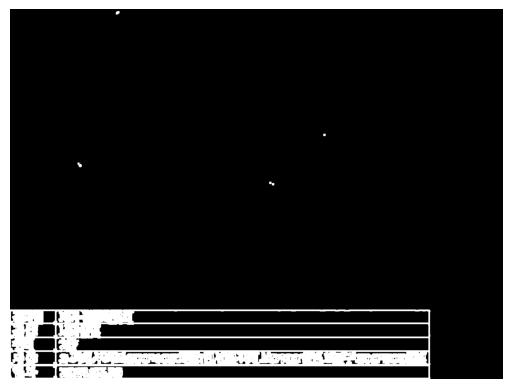

In [394]:
# 팽창-침식 후 윤곽선 찾기
# 사용할 커널
kernel = np.ones((5, 5), np.uint8)

# 팽창 적용
dilated = cv2.dilate(edged, kernel, iterations=1)

# 침식 적용
eroded = cv2.erode(dilated, kernel, iterations=0)

# 윤곽선 검출
contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# 이미지 출력
plt.imshow(cv2.cvtColor(eroded, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

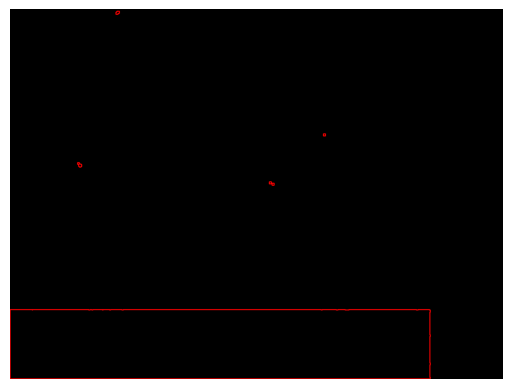

In [395]:
# 검출한 윤곽선 표시
contour_image = np.zeros(shape=image.shape, dtype=np.uint8)
cv2.drawContours(contour_image, contours, -1, (255, 0, 0), 2)

# 이미지 출력
plt.imshow(contour_image)
plt.axis('off')
plt.show()

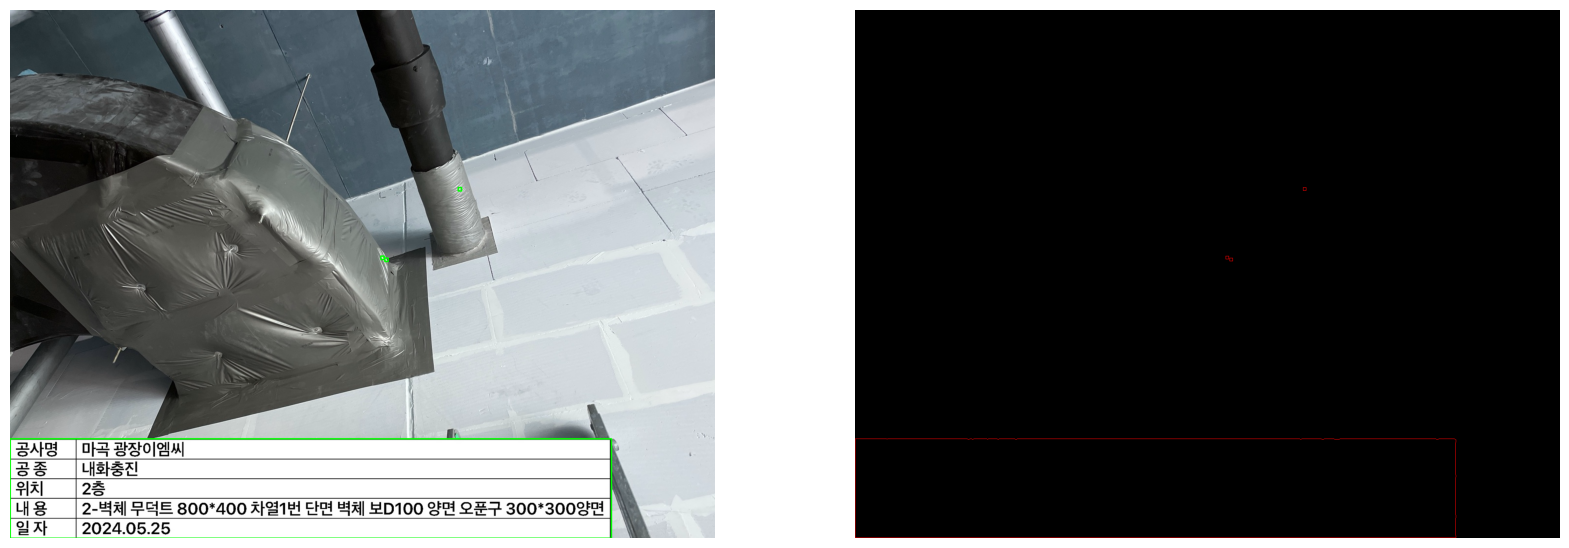

In [396]:
# 사각형으로 근사된 윤곽선 표시
rect_contours = []
rect_contour_image = np.zeros(shape=image.shape, dtype=np.uint8)
rectangles_image = np.copy(image)

for contour in contours:
    if is_contour_rect(contour, tolerance=0.01):
        rect_contours.append(contour)
        draw_contour_rect(rectangles_image, contour)

cv2.drawContours(rect_contour_image, rect_contours, -1, (255, 0, 0), 1)

# 이미지 출력
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(rectangles_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rect_contour_image)
plt.axis('off')

plt.show()

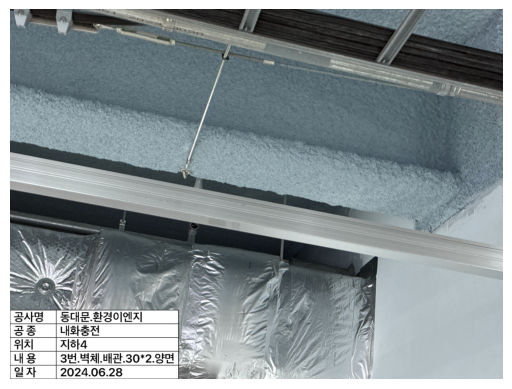

In [406]:
# 좌측 하단에 존재하는 윤곽선 표시
bottom_left_contours_image = np.copy(image)

for contour in contours:
    if is_contour_at_bottom_left(image, contour):
        draw_contour_rect(bottom_left_contours_image, contour)

# 이미지 출력
plt.imshow(bottom_left_contours_image)
plt.axis('off')
plt.show()

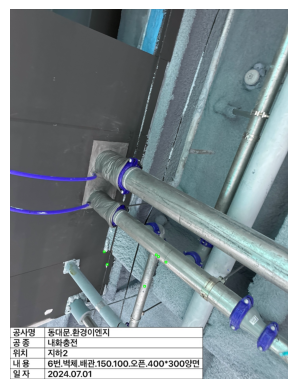

In [349]:
# 표 영역을 검출해 표시
table_image = np.copy(image)

for contour in contours:
    if is_contour_rect(contour, tolerance=0.01) and is_contour_at_bottom_left(image, contour):
        draw_contour_rect(table_image, contour)

# 이미지 출력
plt.imshow(table_image)
plt.axis('off')
plt.show()

### 표 영역 검출 함수

In [409]:
# 표 영역을 검출해 크롭하는 함수
def find_table(image, dilate=0, erode=0):
    # 하얀색을 제외한 색은 모두 검정색으로 처리함
    masked = mask_white(image)
    
    # 흑백으로 변환
    gray = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)

    # 엣지를 검출함
    edged = cv2.Canny(gray, 20, 70)

    # 엣지를 팽창 후 침식시켜 서로 떨어진 윤곽선을 이어줌
    # 사용할 커널
    kernel = np.ones((5, 5), np.uint8)
    # 팽창 적용
    dilated = cv2.dilate(edged, kernel, iterations=dilate)
    # 침식 적용
    eroded = cv2.erode(dilated, kernel, iterations=erode)
    # 윤곽선 찾기
    contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    """
    # 표 영역 후보군
    candidate_contours = [
        contour 
        for contour in contours 
        # if (is_contour_rect(contour, tolerance=tolerance) and is_contour_at_bottom_left(image, contour))
        if is_contour_at_bottom_left(image, contour)
    ]
    """

    # 표 영역(가장 큰 윤곽선 영역)을 잘라냄
    # max_contour = max(candidate_contours, key=cv2.contourArea)
    max_contour = max(contours, key=cv2.contourArea)
    table_image = crop_contour_area(image, max_contour)

    return table_image

In [ ]:
image_path = select_image()

image = cv2.imread(image_path)
table_image = find_table(image, dilate=1, erode=0)

# 이미지 출력
plt.imshow(table_image)
plt.axis('off')
plt.show()

In [ ]:
# 이미지에서 표 영역만 잘라내는 코드
root = Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
image_set_path = askdirectory()
%gui tk

for file_name in os.listdir(image_set_path):
    image = cv2.imread(f"{image_set_path}/{file_name}")
    table_image = find_table(image, dilate=1, erode=0)

    cv2.imwrite(f"{image_set_path.replace('originals', '')}/tables/{file_name}", table_image)